In [2]:
from tensorflow import keras
from src.ParticleNet.PointNet import PointNetLayer
from src.ParticleNet.GlobalPooling import GlobalAveragePoolingLayer
from utilities import utilities
from ML.ParticleCloud.data_loaders import load_data_qg_tagging

#### Loading the Data

In [3]:
X_train, y_train = load_data_qg_tagging(quark_data_path="../../../Data/Trainning/q_jets.csv", gluon_data_path="../../../Data/Trainning/g_jets.csv")
X_val, y_val = load_data_qg_tagging(quark_data_path="../../../Data/Validation/q_jets.csv", gluon_data_path="../../../Data/Validation/g_jets.csv")

In [4]:
print(f"Size of the Training set: {len(X_train)}")
print(f"Size of the Validation set: {len(X_val)}")

Size of the Training set: 251379
Size of the Validation set: 44362


#### Setting up the NN

In [7]:
# MLP for the first conv layer
mlp_jets = keras.Sequential([
    keras.layers.InputLayer(shape=[4]),
    keras.layers.Dense(32),
    # keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(32),
    # keras.layers.BatchNormalization(),
    keras.layers.ReLU()
])

mlp_jets2 = keras.Sequential([
    keras.layers.InputLayer(shape=[32]),
    keras.layers.Dense(64),
    # keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(64),
    # keras.layers.BatchNormalization(),
    keras.layers.ReLU()
])

# MLP for the second convolutional layer
jet_tag_model = keras.Sequential([
    keras.layers.InputLayer(shape=(30, 5)),
    PointNetLayer(mlp=mlp_jets, output_dim=32),
    PointNetLayer(mlp=mlp_jets2, output_dim=64),
    GlobalAveragePoolingLayer(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(2, activation='softmax')
])

jet_tag_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ point_net_layer_2               │ (None, 30, 33)         │         1,216 │
│ (PointNetLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ point_net_layer_3               │ (None, 30, 65)         │         6,272 │
│ (PointNetLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer_1  │ (None, 64)             │             0 │
│ (GlobalAveragePoolingLayer)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,066 (62.76 KB)

 Trainable params: 16,066 (62.76 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
jet_tag_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = jet_tag_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])   

Epoch 1/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7256 - loss: 0.5408 - val_accuracy: 0.7573 - val_loss: 0.5016
Epoch 2/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7581 - loss: 0.5000 - val_accuracy: 0.7619 - val_loss: 0.4911
Epoch 3/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7611 - loss: 0.4947 - val_accuracy: 0.7631 - val_loss: 0.4938
Epoch 4/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7651 - loss: 0.4906 - val_accuracy: 0.7665 - val_loss: 0.4858
Epoch 5/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7663 - loss: 0.4886 - val_accuracy: 0.7676 - val_loss: 0.4865
Epoch 6/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7698 - loss: 0.4837 - val_accuracy: 0.7732 - val_loss: 0.4771
Epoch 7/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7766 - loss: 0.4764 - val_accuracy: 0.7630 - val_loss: 0.4984
Epoch 8/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7754 -

In [10]:
# perfoming the prediction
y_train_pred = jet_tag_model.predict(X_train)
y_val_pred = jet_tag_model.predict(X_val)

7856/7856 ━━━━━━━━━━━━━━━━━━━━ 6s 786us/step
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step


In [11]:
print("Trainnig set:")
utilities.display_metrics(y_true=y_train[:, 0], y_pred=y_train_pred[:, 0] > 0.5)
print("Validation set:")
utilities.display_metrics(y_true=y_val[:, 0], y_pred=y_val_pred[:, 0] > 0.5)

Trainnig set:
Recall: 0.7521
Precision: 0.8094
Confusion Matrix:
[[106230  21834]
 [ 30575  92740]]
Validation set:
Recall: 0.7523
Precision: 0.8077
Confusion Matrix:
[[18703  3897]
 [ 5390 16372]]


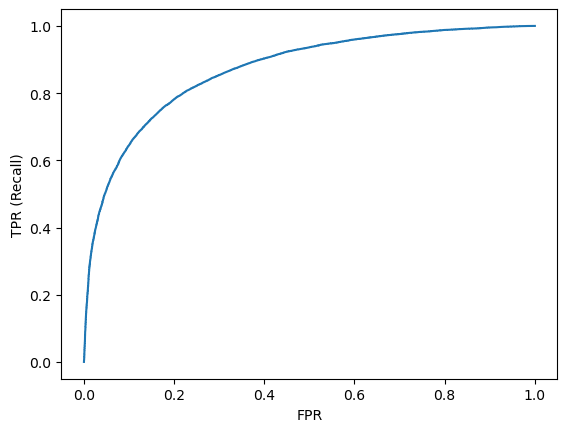

AUC: 0.8703


In [12]:
utilities.display_roc_curve(y_true=y_val[:, 0], y_score=y_val_pred[:, 0])

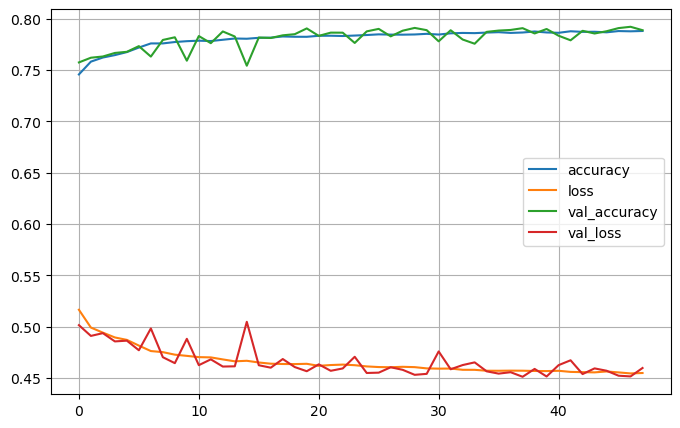

In [13]:
utilities.plot_hist_trainning(history)

In [14]:
utilities.save_model(jet_tag_model, history, "QuarkGluon_Tagging_PointNet")